In [137]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [138]:
import numpy as np
import pandas as pd

In [139]:
 import datetime

In [140]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [141]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [142]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [143]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [144]:
 # Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [145]:
# Create our session (link) from Python to the DB
session = Session(engine)

Climate Analysis

Text(0.5, 0, 'Date')

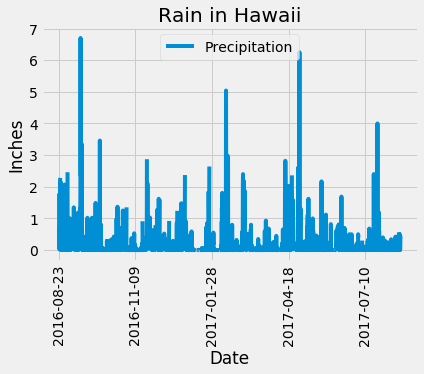

In [154]:
 # Design a query to retrieve the last 12 months of precipitation data and plot the result
    
# Calculate the date 1 year ago from the last data point in the database
last_year = datetime.date(2017, 8, 23) - datetime.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rain_dates = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(rain_dates, columns=['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace=True)
# Sort the dataframe by date
prcp_df = prcp_df.sort_values('Date')
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot=90)
plt.title('Rain in Hawaii')
plt.ylabel('Inches')
plt.xlabel('Date')

In [112]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [113]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [158]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_df = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

station_df

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [169]:
 # Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = 'USC00519281'
summary_temps_df = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"Lowest Temperature: {summary_temps_df[0][0]}")
print(f"Highest Temperature: {summary_temps_df[0][1]}")
print(f"Average Temperature: {round(summary_temps_df[0][2],2)}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


Text(0.5, 0, 'Temperature')

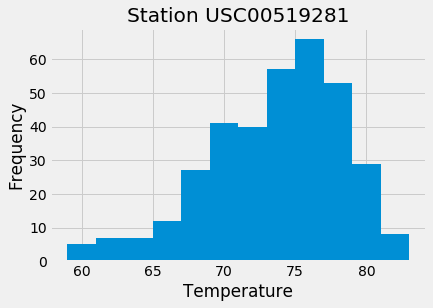

In [165]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
bins = 12

temps = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
                                    filter(Measurement.date >= last_year.strftime('%Y-%m-%d')).\
                                    order_by(Measurement.date).all()
temps = np.ravel(temps)

plt.hist(temps, bins=bins)

plt.title('Station USC00519281')
plt.ylabel("Frequency")
plt.xlabel("Temperature")

Bonus

In [117]:
 # This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [168]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_df = calc_temps('2017-08-06', '2017-08-15')

print(f"Min Temperature: {trip_df[0][0]}")
print(f"Avg Temperature: {round(trip_df[0][1], 2)}")
print(f"Max Temperature: {trip_df[0][2]}")

Min Temperature: 70.0
Avg Temperature: 79.07
Max Temperature: 84.0


In [167]:
 # Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,5))
plt.bar(height=trip_df[1],x='tavg', width=0.1, yerr=(trip_df[2]-trip_df[0]), color='orange', alpha=0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Average Temperature")
plt.ylim(0,100)
plt.tight_layout()

IndexError: list index out of range

<Figure size 216x360 with 0 Axes>

In [120]:
#Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
 #Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
yearly_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,
                               Station.elevation, func.avg(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2017, 8, 15)).group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()

#load into a dataframe
yearly_rainfall_df = pd.DataFrame(yearly_rainfall, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Avg. Precipitation (in.)'])

yearly_rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.367143
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.127500
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.052000
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.003750
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.002857


In [121]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [122]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start = datetime.date(2018,1,1)
end = datetime.date(2018,1,7)
# Use the start and end date to create a range of dates
trip_dates1 = [(start + dt.timedelta(days=x)) for x in range((end-start).days+1)]
# Stip off the year and save a list of %m-%d strings
trip_dates2 = [d.strftime('%m-%d') for d in trip_dates1]
# Loop through the list of %m-%d strings and calculate the normals for each date
for day in trip_dates2:
    normals.append(daily_normals(day)[0])

normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [123]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['min temp', 'avg temp', 'max temp'])
normals_df['date'] = trip_dates1
normals_df.set_index('date', inplace=True)
normals_df.head(8)

,min temp,avg temp,max temp
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


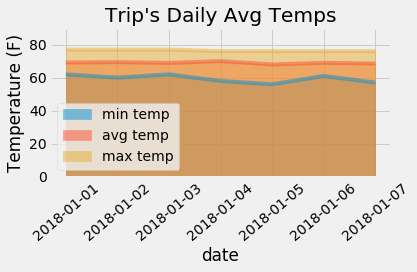

In [124]:
# Plot the daily normals as an area plot with `stacked=False`
Hawaii_daily_normals_df.plot.area(stacked=False)
plt.title("Trip's Daily Avg Temps")
plt.ylabel("Temperature (F)")
plt.ylim(0,90)
plt.xticks(rotation=40)
plt.tight_layout()